In [1]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # Print the CUDA device name
    print("CUDA device:", torch.cuda.get_device_name(0))
    # Set the device to CUDA (GPU)
    device = torch.device('cuda')
else:
    print("CUDA is not available. Using CPU.")
    # Set the device to CPU
    device = torch.device('cpu')

# Create a tensor and move it to the selected device
tensor = torch.tensor([1, 2, 3])
tensor = tensor.to(device)

# Print the device where the tensor is located
print("Tensor device:", tensor.device)


CUDA device: NVIDIA GeForce RTX 4060 Ti
Tensor device: cuda:0


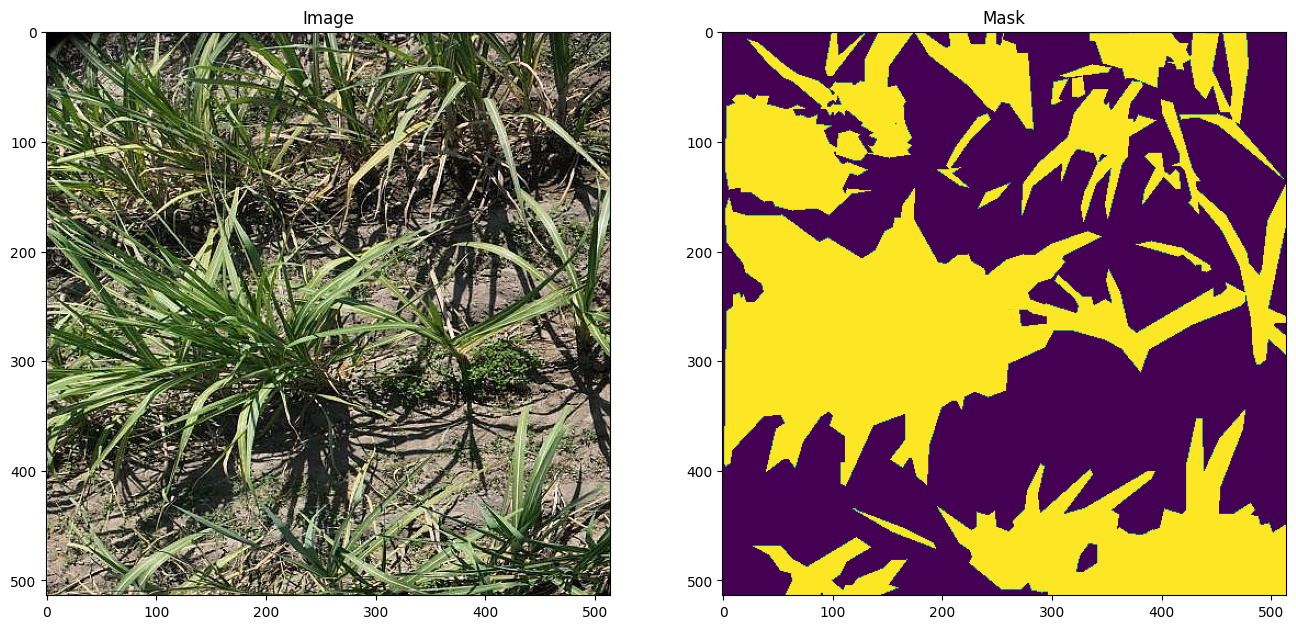

In [2]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image(r"D:\Dataset\sugarcanev3.v1i.voc\PNGImages\DJI_20240220123219_0180_D_JPG_quarter_0_0_png.rf.47d0f02e10b4181575eda04f566b61b0.jpg")
mask = read_image(r"D:\Dataset\sugarcanev3.v1i.voc\PedMasks\DJI_20240220123219_0180_D_JPG_quarter_0_0_png.rf.47d0f02e10b4181575eda04f566b61b0.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [3]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [5]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [6]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model


In [7]:
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
# os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [8]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [9]:
# from utils import collate_fn

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
# dataset = PennFudanDataset(r'D:\Dataset\sugarcanev3.v1i.voc', get_transform(train=True))
# data_loader = torch.utils.data.DataLoader(
#     dataset,
#     batch_size=8,
#     shuffle=True,
#     collate_fn=collate_fn
# )

# # For Training
# images, targets = next(iter(data_loader))
# images = list(image for image in images)
# targets = [{k: v for k, v in t.items()} for t in targets]
# output = model(images, targets)  # Returns losses and detections
# print(output)

# # For inference
# model.eval()
# x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
# predictions = model(x)  # Returns predictions
# print(predictions[0])

In [10]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')




In [11]:
# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('D:\Dataset\sugarcanev3.v1i.voc', get_transform(train=True))
dataset_test = PennFudanDataset('D:\Dataset\sugarcanev3.v1i.voc', get_transform(train=False))

In [12]:
# # split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()
# dataset = torch.utils.data.Subset(dataset, indices[:-4])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-3:])

In [13]:
import torch

# Assuming you already have 'dataset' and 'dataset_test'

# Get the number of samples in the dataset
total_samples = len(dataset)

# Calculate the number of samples for training and testing
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size

# Create a list of indices for shuffling
indices = torch.randperm(total_samples).tolist()

# Split the dataset into train and test subsets using the indices
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Create train and test subsets using Subset class
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Check if there are any remaining samples in the test dataset
if len(test_indices) < test_size:
    test_size = len(test_indices)
    remaining_indices = test_indices

    # Extend the test indices with remaining samples from the dataset
    remaining_indices.extend(indices[-test_size:])
    test_indices = remaining_indices

    # Create test subset using Subset class
    test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Check if the test dataset needs to be extended with samples from dataset_test
if len(test_indices) < test_size:
    remaining_samples = test_size - len(test_indices)
    remaining_indices = indices[-remaining_samples:]

    # Extend the test indices with samples from dataset_test
    test_indices.extend(remaining_indices)

    # Create test subset using Subset class
    test_dataset = torch.utils.data.ConcatDataset([test_dataset, torch.utils.data.Subset(dataset_test, remaining_indices)])

# Verify the lengths of train and test datasets
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))


Train dataset size: 1332
Test dataset size: 333


In [14]:
# # Check number of samples in the train and test sets
# print("Number of samples in train set:", len(dataset))
# print("Number of samples in test set:", len(dataset_test))



In [15]:
from utils import collate_fn

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn
)


In [16]:
from utils import collate_fn

data_loader_test = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn
)

In [17]:
# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)
    
import torch

# Define the directory where you want to save the models
save_dir = 'saved_models/'

# Let's train it just for 2 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    
    # Update the learning rate
    lr_scheduler.step()
    
    # Evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    
    # Save the model after each epoch
    torch.save(model.state_dict(), save_dir + 'model_epoch_{}.pth'.format(epoch))
    print("Model saved after epoch", epoch)

print("Training complete! Models saved.")


Epoch: [0]  [  0/167]  eta: 0:05:23  lr: 0.000035  loss: 3.5333 (3.5333)  loss_classifier: 0.5954 (0.5954)  loss_box_reg: 0.0803 (0.0803)  loss_mask: 2.8131 (2.8131)  loss_objectness: 0.0198 (0.0198)  loss_rpn_box_reg: 0.0247 (0.0247)  time: 1.9380  data: 0.3072  max mem: 8093
Epoch: [0]  [ 10/167]  eta: 0:03:43  lr: 0.000336  loss: 1.8405 (2.2407)  loss_classifier: 0.4355 (0.4060)  loss_box_reg: 0.0958 (0.0913)  loss_mask: 1.4204 (1.7023)  loss_objectness: 0.0137 (0.0140)  loss_rpn_box_reg: 0.0269 (0.0272)  time: 1.4234  data: 0.3091  max mem: 8260
Epoch: [0]  [ 20/167]  eta: 0:03:26  lr: 0.000637  loss: 1.0613 (1.5911)  loss_classifier: 0.1007 (0.2463)  loss_box_reg: 0.0771 (0.0815)  loss_mask: 0.7974 (1.2031)  loss_objectness: 0.0149 (0.0182)  loss_rpn_box_reg: 0.0363 (0.0421)  time: 1.3780  data: 0.3181  max mem: 8260
Epoch: [0]  [ 30/167]  eta: 0:03:11  lr: 0.000938  loss: 0.8374 (1.3451)  loss_classifier: 0.0662 (0.1894)  loss_box_reg: 0.0771 (0.0839)  loss_mask: 0.6041 (1.0081) 

In [18]:
# import torch.optim as optim
# import ray
# from ray import tune
# from ray.tune import CLIReporter

# # Define your training function
# def train_func(config):
#     # Define your model, optimizer, data loaders, etc. here
#     model = ...
#     optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
#     # Callbacks initialization
#     lr_reduce = CustomLRScheduler(optimizer, reduce_factor=0.6, patience=2, min_lr=1e-7)
#     early_stop = EarlyStopping(patience=5, mode='max')
#     checkpoint = ModelCheckpoint('faster_rcnn.pt')
#     log_dir = f"./logs/ResNet18-{datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')}"
#     os.makedirs(log_dir, exist_ok=True)
#     tensorboard = TensorBoard(log_dir=log_dir)

#     for epoch in range(num_epochs):
#         train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
#         val_AP = evaluate_AP(model, data_loader_test, device=device)
#         lr_reduce.step(epoch, val_AP)
#         early_stop(val_AP)

#         if early_stop.early_stop:
#             print("Early stopping")
#             break

#         checkpoint(model, val_AP)
#         tensorboard.add_scalar('val_AP', val_AP, epoch)

#     tensorboard.close()
#     print("Training complete! Model saved as 'faster_rcnn.pt'.")

# # Define the search space
# config = {
#     "lr": tune.loguniform(0.001, 0.1),
#     "momentum": tune.uniform(0.1, 0.9)
# }

# # Initialize Ray
# ray.init()

# # Configure the reporter
# reporter = CLIReporter(
#     parameter_columns=["lr", "momentum"],
#     metric_columns=["val_AP", "training_iteration"])

# # Start Ray Tune training
# analysis = tune.run(
#     train_func,
#     config=config,
#     num_samples=10,
#     resources_per_trial={"cpu": 2},
#     progress_reporter=reporter)

# # Get the best hyperparameters
# best_trial = analysis.get_best_trial(metric="val_AP", mode="max")
# print("Best trial config:", best_trial.config)


In [19]:
# predictions = model([x, ])
# pred = predictions[0]
# print(pred.keys())  # This will print all the keys in the prediction dictionary


In [20]:
# # ... (prediction and bounding box processing)
# output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")
# # plt.show()  # Display the image


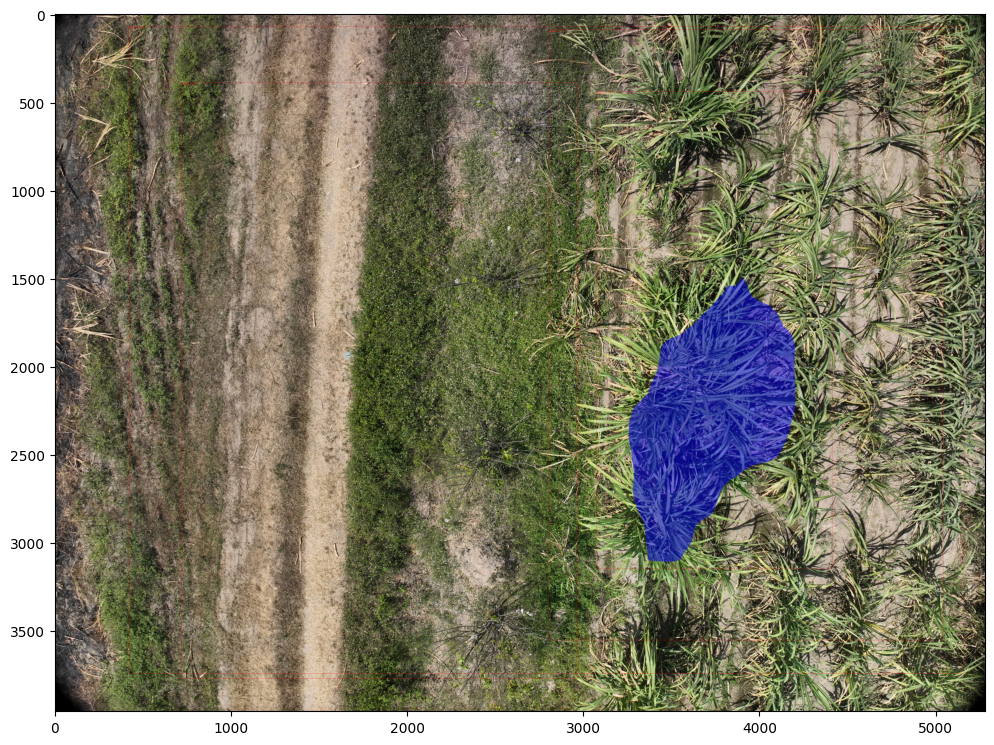

In [21]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image(r"D:\Dataset\DJI Data\raw file\DJI_202402201210_009_area1\DJI_20240220121433_0035_D.JPG")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"Sugarcane: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

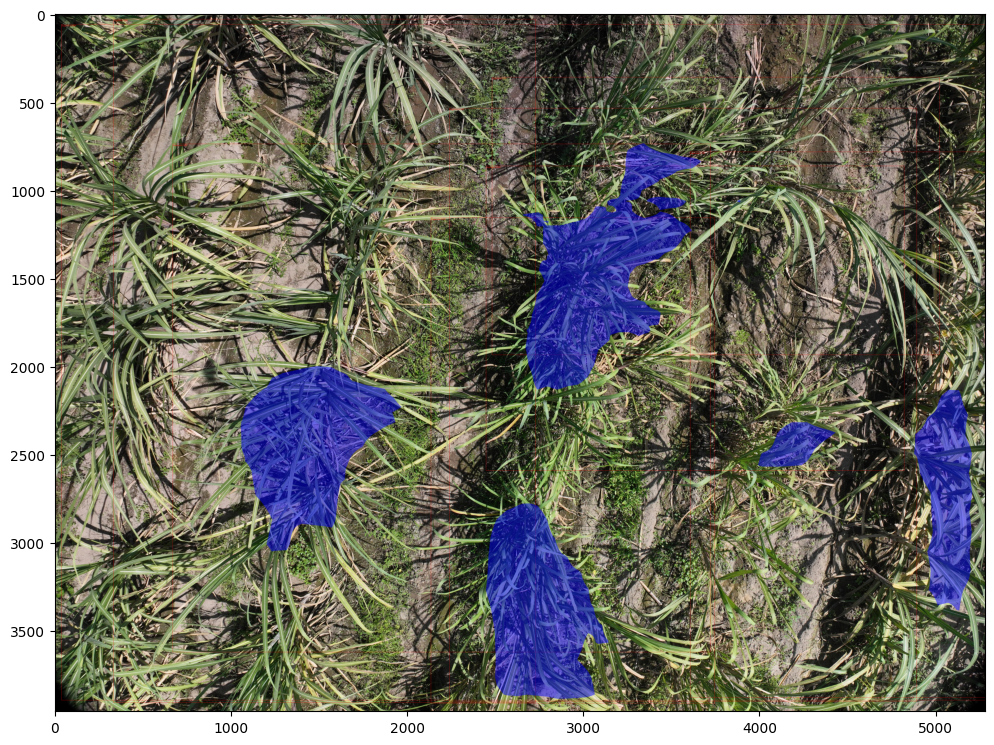

In [22]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image(r"D:\Dataset\DJI Data\raw file\DJI_202402201210_010_manual_jpg\DJI_20240220122841_0071_D.JPG")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"Sugarcane: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

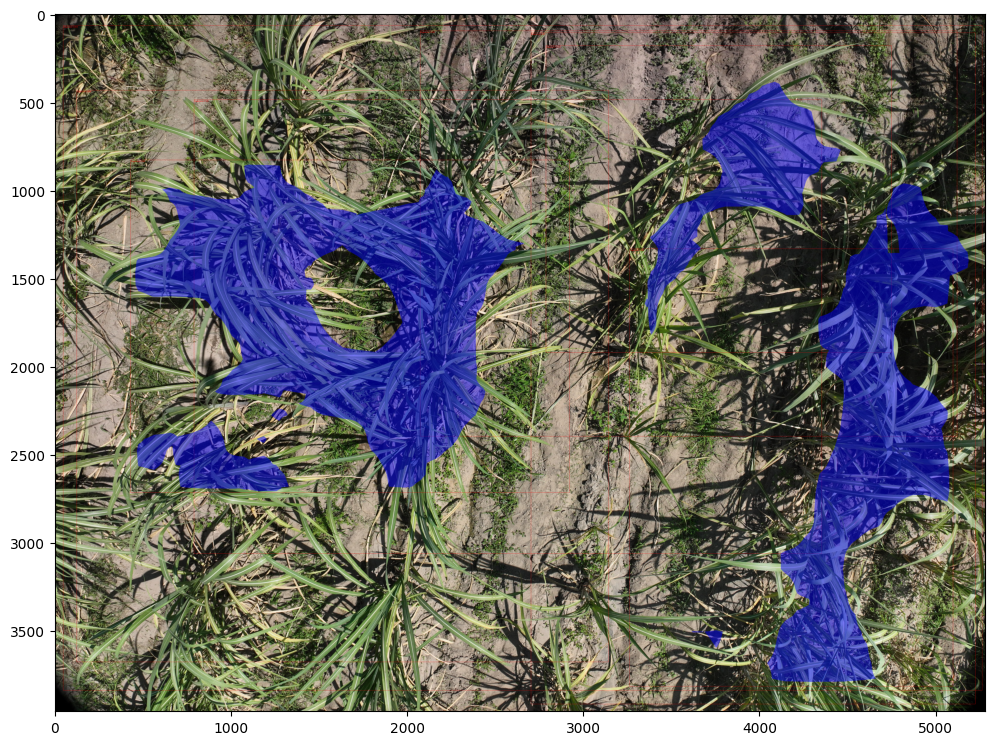

In [23]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image(r"D:\Dataset\DJI Data\raw file\DJI_202402201210_010_manual_jpg\DJI_20240220122931_0096_D.JPG")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"Sugarcane: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [24]:
# # Save the model to a file
# torch.save(model.state_dict(), 'simple_model.pth')

In [25]:
# import torch
# import torchvision
# from torchvision.transforms import functional as F
# from PIL import Image

# # Load the saved model
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)  # Instantiate a new model instance
# model.load_state_dict(torch.load('simple_model.pth'))  # Load the saved state dictionary
# model.eval()  # Set the model to evaluation mode

In [26]:
# import matplotlib.pyplot as plt

# from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


# image = read_image(r"I:\Dataset\DJI Data\raw file\DJI_202402201210_010_manual_jpg_test\DJI_20240220123542_0281_D.JPG")
# eval_transform = get_transform(train=False)

# model.eval()
# with torch.no_grad():
#     x = eval_transform(image)
#     # convert RGBA -> RGB and move to device
#     x = x[:3, ...].to(device)
#     predictions = model([x, ])
#     pred = predictions[0]


# image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
# image = image[:3, ...]
# pred_labels = [f"Sugarcane: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
# pred_boxes = pred["boxes"].long()
# output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# masks = (pred["masks"] > 0.7).squeeze(1)
# output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


# plt.figure(figsize=(12, 12))
# plt.imshow(output_image.permute(1, 2, 0))